In [20]:
############ INPUT FILES  ##############

idf_file   = 'energy_plus/input_building/idf/upgraded/' + 'RefBldgWarehouseNew2004_v1.4_7.2_6A_USA_MN_MINNEAPOLIS.idf'
epw_file   = 'energy_plus/input_building/epw/' + 'CAN_ON_Toronto.716240_CWEC.epw'
ehub_file  = 'ehub/input_ehub_excel/' + 'simple_warehouse_on_five.xlsx'

In [21]:
########### OUTPUT FILES ###############

# EnergyPlus
output_dir = 'energy_plus/output_energy_plus'
error_dir  = 'energy_plus/output_energy_plus'
# EHUB
res_file   = 'ehub/output_ehub_excel/' + "simple_warehouse_on_results.xlsx"
# PV FACTORS
rendered_files = "rendered_pv_factors/on/"
# GA
ga_output_dir = 'ga/on/warehouse/1/'
# panel price 400, 200, 106
ga_400_file = ga_output_dir + "panel_400_dual.xlsx"
ga_400_proc = ga_output_dir + "panel_400_dual_processed.xlsx"

ga_200_file = ga_output_dir + "panel_200_dual.xlsx"
ga_200_proc = ga_output_dir + "panel_200_dual_processed.xlsx"

ga_106_file = ga_output_dir + "panel_106_dual.xlsx"
ga_106_proc = ga_output_dir + "panel_106_dual_processed.xlsx"

# panel price 400, 200, 106
ga_400_file_s = ga_output_dir + "panel_400_sing.xlsx"
ga_400_proc_s = ga_output_dir + "panel_400_sing_processed.xlsx"

ga_200_file_s = ga_output_dir + "panel_200_sing.xlsx"
ga_200_proc_s = ga_output_dir + "panel_200_sing_processed.xlsx"

ga_106_file_s = ga_output_dir + "panel_106_sing.xlsx"
ga_106_proc_s = ga_output_dir + "panel_106_sing_processed.xlsx"

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML


# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [24]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir, 
                                   epw_file=epw_file, err_dir=error_dir) 

## the North Axis
The north axis gets grabbed automatically from the idf.

In [25]:
pvbuilding.North_Axis

0.0

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [26]:
# Determine the hourly electricity use
pvbuilding.run_ep()

energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_6A_USA_MN_MINNEAPOLIS.idf


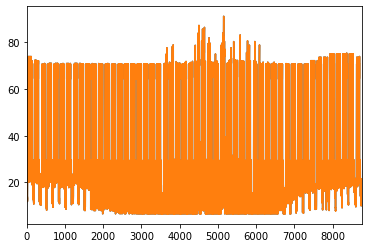

Roof area is 4,598 m²
Total surface area 4,835 m²
The maximum power used is 91 kW
The minimum power used is 6 kW
The average power used is 31 kW
The total Electricity use is 271,435 kWh or 271 MWh
This building is in the **Medium General Service** Rate
Electricity per surface area: 56 kWh/m²
Electricity per surface area: 0.2021 GJ/m²


In [27]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()
pvbuilding.summerize_the_building()

## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [28]:
pvbuilding.get_roof_area()
pvbuilding.p_roof_area()

Roof area is 4,598 m²


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [29]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building.
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

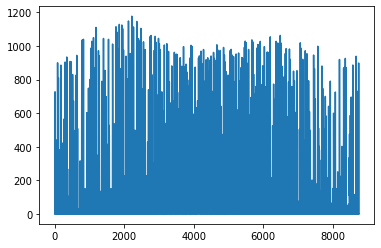

In [30]:
irr = pvpanel.irradiance(180,45,0.6)
plt.plot(irr);

# (C) EnergyHub - Cost and Capacity installed

## Hourly model for Ontario
![alt text](images/Ontario_Electricity_Prices.PNG "Logo Title Text 1")

In [33]:
from pv_model import pvModel
# These are the fixed five panels that we are interested in
azi = [180,215,245,215,130]
tilt = [5,55,10,35,5]
gcr = [0.9,0.35,0.9,0.7,0.9]
# Setup the values array
pan_vals = []
pan_vals.extend(azi)
pan_vals.extend(tilt)
pan_vals.extend(gcr)
print(pan_vals)
# setup the gcr
area_per_panel = [pvpanel.pp['pvrow_depth']*pvpanel.pp['pvrow_width']/gcr[i] for i in range(5)]
roof_area_per_unit_capacity = {"PV{}".format(i):area_per_panel[i]  for i in range(5)}
# Here's where we instantiate our model. Nothing is solved at this point.
print("Loading the model")
my_model = pvModel.RoofModelOn(excel         = ehub_file,\
                               MAX_ROOF_AREA = pvbuilding.roof_area,\
                               resultsFile   = res_file,\
                               EP_LOAD       = pvbuilding.hourly_electricity,\
                               ROOF_AREA_CAP = roof_area_per_unit_capacity)
my_model.eval_model(pan_vals,200,pvpanel)

[180, 215, 245, 215, 130, 5, 55, 10, 35, 5, 0.9, 0.35, 0.9, 0.7, 0.9]
Loading the model
Start Evaluation
Compiling and setting: Irra0
Compiling and setting: Irra1
Compiling and setting: Irra2
Compiling and setting: Irra3
Compiling and setting: Irra4
Generated the panel irradiance in   0s
Starting recompile
Recompiled the model in  94s
Starting solver
Solved the model in  24s
[0.0, 0.0, 0.0, 0.0, 280.238]
23683.1


After evaluating the model we can plot the results. This is a pie chart that breaks down the total cost into the off,on and mid peak costs. 

Total Electricity Imported from the grid 210,343 kWh


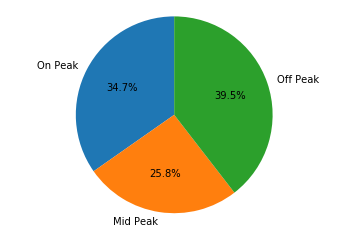

In [34]:
my_model.make_pie_chart()

In [35]:
my_model.generated_percentage()

Total Electricity Load from the building: 271,435 kWh
Total Electricity Generated from PV: 72,521 kWh
Percentage: 26.7%


# (D) GA - Optimize the model

In [ ]:
from pv_model import pvOptimizer

range_azi  = range(90,270,5)
range_tilt = range(1,61,5)
range_gcr  = np.arange(0.2, .95, 0.05)

## Run a panel price of 400

### Multi objective Minimize cost Maximize Installed Capacity

In [ ]:
price = 400

pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                 range_tilt=range_tilt,
                 range_gcr=range_gcr,
                 pvpanel=pvpanel,
                 price=price,
                 store_file=ga_400_file,
                 ehub_file=ehub_file,
                 roof_area=pvbuilding.roof_area,
                 res_file=res_file,
                 hourly_electricity=pvbuilding.hourly_electricity,
                 roof_area_per_unit_capacity=roof_area_per_unit_capacity)
pvoptimizer.runGADUAL(100,20)
pvoptimizer.processGA(ga_400_proc)

### Single objective Minimize cost

In [ ]:
pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                 range_tilt=range_tilt,
                 range_gcr=range_gcr,
                 pvpanel=pvpanel,
                 price=price,
                 store_file=ga_400_file_s,
                 ehub_file=ehub_file,
                 roof_area=pvbuilding.roof_area,
                 res_file=res_file,
                 hourly_electricity=pvbuilding.hourly_electricity,
                 roof_area_per_unit_capacity=roof_area_per_unit_capacity)
pvoptimizer.runGASINGLE(100,20)
pvoptimizer.processGA(ga_400_proc_s)

## Run a panel price of 200

### Multi objective Minimize cost Maximize Installed Capacity

In [ ]:
price = 200

pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                 range_tilt=range_tilt,
                 range_gcr=range_gcr,
                 pvpanel=pvpanel,
                 price=price,
                 store_file=ga_200_file,
                 ehub_file=ehub_file,
                 roof_area=pvbuilding.roof_area,
                 res_file=res_file,
                 hourly_electricity=pvbuilding.hourly_electricity,
                 roof_area_per_unit_capacity=roof_area_per_unit_capacity)
pvoptimizer.runGADUAL(100,20)
pvoptimizer.processGA(ga_200_proc)

### Single objective Minimize cost

In [ ]:
pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                 range_tilt=range_tilt,
                 range_gcr=range_gcr,
                 pvpanel=pvpanel,
                 price=price,
                 store_file=ga_200_file_s,
                 ehub_file=ehub_file,
                 roof_area=pvbuilding.roof_area,
                 res_file=res_file,
                 hourly_electricity=pvbuilding.hourly_electricity,
                 roof_area_per_unit_capacity=roof_area_per_unit_capacity)
pvoptimizer.runGASINGLE(100,20)
pvoptimizer.processGA(ga_200_proc_s)

## Run a panel price of 106

### Multi objective Minimize cost Maximize Installed Capacity

In [ ]:
price = 106

pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                 range_tilt=range_tilt,
                 range_gcr=range_gcr,
                 pvpanel=pvpanel,
                 price=price,
                 store_file=ga_106_file,
                 ehub_file=ehub_file,
                 roof_area=pvbuilding.roof_area,
                 res_file=res_file,
                 hourly_electricity=pvbuilding.hourly_electricity,
                 roof_area_per_unit_capacity=roof_area_per_unit_capacity)
pvoptimizer.runGADUAL(100,20)
pvoptimizer.processGA(ga_106_proc)

### Single objective Minimize cost

In [ ]:
pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                 range_tilt=range_tilt,
                 range_gcr=range_gcr,
                 pvpanel=pvpanel,
                 price=price,
                 store_file=ga_106_file_s,
                 ehub_file=ehub_file,
                 roof_area=pvbuilding.roof_area,
                 res_file=res_file,
                 hourly_electricity=pvbuilding.hourly_electricity,
                 roof_area_per_unit_capacity=roof_area_per_unit_capacity)
pvoptimizer.runGASINGLE(100,20)
pvoptimizer.processGA(ga_106_proc_s)